### CBOW = Continuous Bag of Words
#### Our objective: to obtain vector embeddings of 20,000 common english language words by training for their contextual meaning.
#### AKA: subpar version of Word2Vec

In [1]:
import gensim.downloader as api
import tensorflow

dataset = api.load("text8")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

[==================================================] 100.0% 31.6/31.6MB downloaded


In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [3]:
vocab_size = 20000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(dataset)
sequences = tokenizer.texts_to_sequences(dataset)

tokenizer.word_index

{'the': 1,
 'of': 2,
 'and': 3,
 'one': 4,
 'in': 5,
 'a': 6,
 'to': 7,
 'zero': 8,
 'nine': 9,
 'two': 10,
 'is': 11,
 'as': 12,
 'eight': 13,
 'for': 14,
 's': 15,
 'five': 16,
 'three': 17,
 'was': 18,
 'by': 19,
 'that': 20,
 'four': 21,
 'six': 22,
 'seven': 23,
 'with': 24,
 'on': 25,
 'are': 26,
 'it': 27,
 'from': 28,
 'or': 29,
 'his': 30,
 'an': 31,
 'be': 32,
 'this': 33,
 'which': 34,
 'at': 35,
 'he': 36,
 'also': 37,
 'not': 38,
 'have': 39,
 'were': 40,
 'has': 41,
 'but': 42,
 'other': 43,
 'their': 44,
 'its': 45,
 'first': 46,
 'they': 47,
 'some': 48,
 'had': 49,
 'all': 50,
 'more': 51,
 'most': 52,
 'can': 53,
 'been': 54,
 'such': 55,
 'many': 56,
 'who': 57,
 'new': 58,
 'used': 59,
 'there': 60,
 'after': 61,
 'when': 62,
 'into': 63,
 'american': 64,
 'time': 65,
 'these': 66,
 'only': 67,
 'see': 68,
 'may': 69,
 'than': 70,
 'world': 71,
 'i': 72,
 'b': 73,
 'would': 74,
 'd': 75,
 'no': 76,
 'however': 77,
 'between': 78,
 'about': 79,
 'over': 80,
 'years':

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Input, Embedding, Lambda
from tensorflow.keras.models import Model

In [5]:
import random
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [6]:
context_size = 10
embedding_dim = 50

i = Input(shape=(context_size,))
x = Embedding(vocab_size, embedding_dim)(i)
x = Lambda(lambda t: tf.reduce_mean(t, axis=1))(x)
x = Dense(vocab_size, activation='softmax')(x)

model = Model(i, x)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding (Embedding)       (None, 10, 50)            1000000   
                                                                 
 lambda (Lambda)             (None, 50)                0         
                                                                 
 dense (Dense)               (None, 20000)             1020000   
                                                                 
Total params: 2,020,000
Trainable params: 2,020,000
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

In [9]:
half_context_size = context_size // 2

def data_generator(sequences, batch_size=128):
  X_batch = np.zeros((batch_size, context_size))
  Y_batch = np.zeros(batch_size)
  n_batches = int(np.ceil(len(sequences) / batch_size))

  while True:
    random.shuffle(sequences)

    # one epoch will be one pass through the data
    for i in range(n_batches):
      batch_sequences = sequences[i * batch_size:(i + 1) * batch_size]

      current_batch_size = len(batch_sequences) # may be less than batch_size
      for ii in range(current_batch_size):
        seq = batch_sequences[ii]
        j = np.random.randint(0, len(seq) - context_size - 1)
        x1 = seq[j:j + half_context_size]
        x2 = seq[j + half_context_size + 1:j + context_size + 1]
        # x = x1 + x2
        # X_batch[ii] = x
        X_batch[ii, :half_context_size] = x1
        X_batch[ii, half_context_size:] = x2
        y = seq[j + half_context_size]
        Y_batch[ii] = y

      yield X_batch[:current_batch_size], Y_batch[:current_batch_size]

In [10]:
batch_size = 128
r = model.fit(
  data_generator(sequences, batch_size),
  epochs=10000,
  steps_per_epoch=int(np.ceil(len(sequences) / batch_size))
)

Epoch 1/10000
14/14 [==============================] - 2s 49ms/step - loss: 9.8981 - accuracy: 0.0388
Epoch 2/10000
14/14 [==============================] - 1s 43ms/step - loss: 9.8842 - accuracy: 0.0811
Epoch 3/10000
14/14 [==============================] - 1s 45ms/step - loss: 9.8644 - accuracy: 0.0688
Epoch 4/10000
14/14 [==============================] - 1s 46ms/step - loss: 9.8337 - accuracy: 0.0653
Epoch 5/10000
14/14 [==============================] - 1s 45ms/step - loss: 9.7873 - accuracy: 0.0758
Epoch 6/10000
14/14 [==============================] - 1s 44ms/step - loss: 9.7125 - accuracy: 0.0717
Epoch 7/10000
14/14 [==============================] - 1s 44ms/step - loss: 9.6086 - accuracy: 0.0653
Epoch 8/10000
14/14 [==============================] - 1s 44ms/step - loss: 9.5043 - accuracy: 0.0600
Epoch 9/10000
14/14 [==============================] - 1s 44ms/step - loss: 9.3226 - accuracy: 0.0817
Epoch 10/10000
14/14 [==============================] - 1s 47ms/step - loss: 9.131

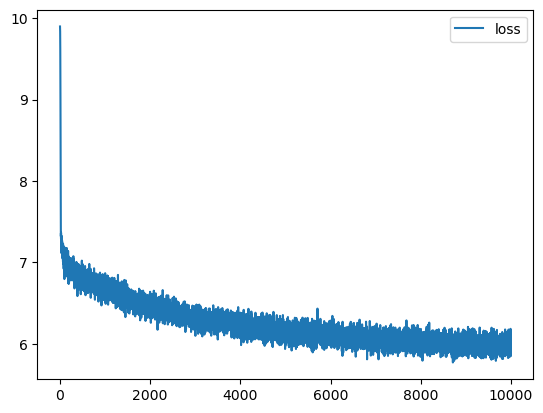

In [11]:
plt.plot(r.history['loss'], label='loss')
plt.legend();

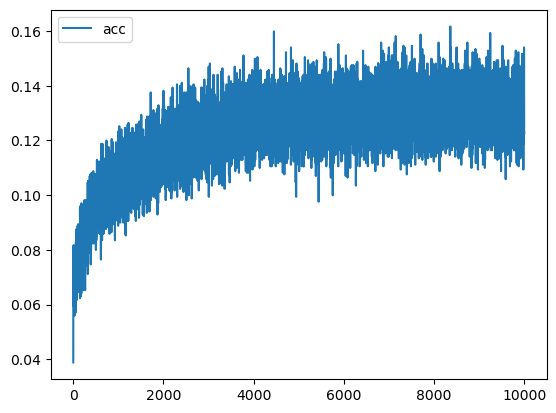

In [12]:
plt.plot(r.history['accuracy'], label='acc')
plt.legend();

In [13]:
embeddings = model.layers[1].get_weights()[0]
embeddings

array([[-0.02410002,  0.03624469,  0.04384006, ...,  0.02396232,
         0.04405816,  0.04269155],
       [ 0.76053166,  0.55989563,  0.7329449 , ..., -0.496832  ,
         0.28875694,  0.6719258 ],
       [ 0.5577027 ,  1.1394446 , -0.7396648 , ...,  0.6407553 ,
         1.3273181 ,  0.2784624 ],
       ...,
       [ 0.12692475, -0.05632548, -0.2967959 , ..., -0.14562918,
         0.09982391, -0.72265714],
       [ 0.2537654 ,  0.40111658, -0.40797234, ...,  0.05605168,
        -0.700225  , -0.13615991],
       [ 0.40293354,  0.20195878, -0.63440454, ...,  0.0037837 ,
         0.15471672, -0.3338468 ]], dtype=float32)

In [14]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
neighbors.fit(embeddings)

NearestNeighbors(algorithm='ball_tree')

In [15]:
def print_neighbors(query):
  query_idx = tokenizer.word_index[query]
  query = embeddings[query_idx:query_idx + 1]
  distances, indices = neighbors.kneighbors(query)
  for idx in indices[0]:
    word = tokenizer.index_word[idx]
    print(word)

In [16]:
print_neighbors('uncle')

uncle
grandfather
widow
nephew
grandmother


In [17]:
print_neighbors('paris')

paris
vienna
villa
leipzig
venice


In [18]:
def get_embedding(word):
  idx = tokenizer.word_index[word]
  return embeddings[idx:idx + 1]

england = get_embedding('england')

english = get_embedding('english')
australian = get_embedding('australian')

# australia - australian = england - english in resulting embedding space
# expected query = australia
query = england - english + australian

distances, indices = neighbors.kneighbors(query)
for idx in indices[0]:
  word = tokenizer.index_word[idx]
  print(word)

australia
canada
victoria
georgia
england
